# Scene Classification

# Importing and Getting Dataset

We begin by first importing all needed libraries and then we get the dataset from the Kaggle webiste. To access the dataset from the Kaggle website we need a username and key. This is why we download the 'kaggle.json' file.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path
from keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras import Model
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Add
from tensorflow.keras.initializers import glorot_uniform

Using TensorFlow backend.


In [0]:
#installs kaggle API
!pip install kaggle

In [0]:
#this gets the 'kaggle.json' file that contains the username and key to access the Kaggle dataset.
from google.colab import files
files.upload() #once executing this cell, click on the 'Choose Files' option and then select the downloaded 'kaggle.json' file 

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"abdullahmcdonald","key":"807b23f25196dd273b239e0ea4e8393f"}'}

In [0]:
#this stores the 'kaggle.json' file in the folder called kaggle
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/

#change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#downloading Kaggle dataset
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#since the Kaggle dataset is downloaded as a zip file, we need to extract it

from zipfile import ZipFile
file_name = "intel-image-classification.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# Dataset Exploration

In this section we display the original dataset's scene category distribution and the result after down-sampling each scene category to the scene category that contains the least number of images

In [0]:
def dataset(path_folders_1, path_folders_2, folders_1, folders_2, size, downsampling=False):
    image_data = []
    labels = []
    class_labels_dict = {'buildings':0, 'forest':1, 'glacier':2, 'sea':3, 'street':4, 'mountain':5}
    num_images_per_class = []

    #this gets the number of images in each class. We need this so that we can get the class with lowest number of images.
    #We need this so that we can balance the classes.
    for folder in path_folders_1:
        counter = 0
        for img_path in folder.glob("*.jpg"):
            counter+=1
        num_images_per_class.append(counter)

    min_num_images_to_read_1 = min(num_images_per_class)
    

    for folder in path_folders_2:
        class_label = str(folder).split("/")[-1]
        counter = 0
        
        #iterate over folder and select the images in each folder
        for img_path in folder.glob("*.jpg"):
            if (downsampling==True):
                if (counter < min_num_images_to_read_1):
                    img = image.load_img(img_path, target_size=size)
                    img_array = image.img_to_array(img)
                    image_data.append(img_array)
                    labels.append(class_label)
                    counter+=1
            else:
                img = image.load_img(img_path, target_size=size)
                img_array = image.img_to_array(img)
                image_data.append(img_array)
                labels.append(class_label)
                counter+=1
           
    num_images_per_class=[]
    for folder in folders_1:
        counter = 0
        for img_path in folder.glob("*.jpg"):
            counter+=1
        num_images_per_class.append(counter)

    min_num_images_to_read_2 = min(num_images_per_class)
    
    for folder in folders_2:
        class_label = str(folder).split("/")[-1]
        counter = 0
        for img_path in folder.glob("*.jpg"):
            if (downsampling==True):
                if (counter < min_num_images_to_read_2):
                    img = image.load_img(img_path, target_size=size)
                    img_array = image.img_to_array(img)
                    image_data.append(img_array)
                    labels.append(class_label)
                    counter+=1
            else:
                img = image.load_img(img_path, target_size=size)
                img_array = image.img_to_array(img)
                image_data.append(img_array)
                labels.append(class_label)
                counter+=1

    if (downsampling == True):            
        return image_data, labels, min_num_images_to_read_1 + min_num_images_to_read_2
    
    return image_data, labels


In [0]:
path = Path(r'/content/seg_train/seg_train')
folders_path_1 = path.glob("*")
folders_path_2 = path.glob("*")
path_test = Path(r'/content/seg_test/seg_test')
folder_test = path_test.glob("*")
folder_test_2 = path_test.glob("*")
X, Y = dataset(folders_path_1, folders_path_2, folder_test, folder_test_2, size=(150, 150))
X = np.array(X)

Intel Scene Classification dataset contains
----------------

17034 images of size 150x150x3



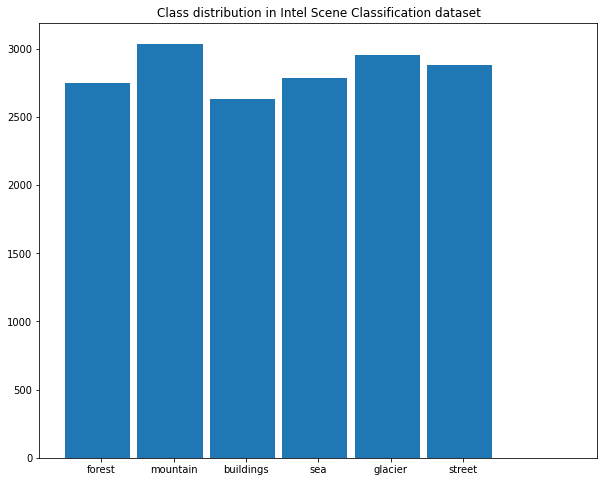

In [0]:
print('Intel Scene Classification dataset contains\n----------------\n')

print('%d images of size %dx%dx%d\n'%(X.shape[0], X.shape[1], X.shape[2], X.shape[3]))

plt.figure(figsize=(10,8))
plt.hist(Y, np.linspace(-0.5, 6.5, 8), width=0.9)
plt.xticks(np.linspace(0,5,6))
plt.title("Class distribution in Intel Scene Classification dataset")
plt.savefig("class_distribution", transparent=True)
plt.show()


CLASS DISTRIBUTION AFTER DOWNSAMPLING

In [0]:
path = Path(r'/content/seg_train/seg_train')
folders_path_1 = path.glob("*")
folders_path_2 = path.glob("*")
path_test = Path(r'/content/seg_test/seg_test')
folder_test = path_test.glob("*")
folder_test_2 = path_test.glob("*")
X, Y, minimum = dataset(folders_path_1, folders_path_2, folder_test, folder_test_2, size=(150, 150), downsampling=True)
X = np.array(X)

After down-sampling the scene categories, the Intel Scene Classification dataset contains
----------------

15768 images of size 150x150x3 with 2628 images per scene category



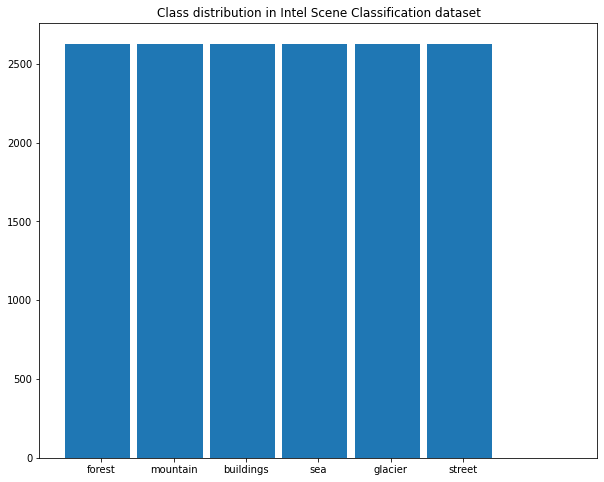

In [0]:
print('After down-sampling the scene categories, the Intel Scene Classification dataset contains\n----------------\n')

print('%d images of size %dx%dx%d with %d images per scene category\n'%(X.shape[0], X.shape[1], X.shape[2], X.shape[3], minimum))

plt.figure(figsize=(10,8))
plt.hist(Y, np.linspace(-0.5, 6.5, 8), width=0.9)
plt.xticks(np.linspace(0,5,6))
plt.title("Class distribution in Intel Scene Classification dataset")
plt.savefig("class_distribution", transparent=True)
plt.show()

# Experiment 1

Aim: Experiment 1 investigates whether data augmentation techniques can improve the classification accuracy of the ResNet model

The create_dataset function essentially creates the dataset for experiment 1. It takes as input 2 path folders (where the dataset is stored) and also takes in the size/resolution of the images that you want the dataset to contain. As output it creates arrays that contain the images and its scene category labels and also gives the number of images that each scene category contains

In [0]:
def create_dataset(path_folders_1, path_folders_2, size):
    image_data = []
    labels = []
    class_labels_dict = {'buildings':0, 'forest':1, 'glacier':2, 'sea':3, 'street':4, 'mountain':5}
    num_images_per_class = []

    #this gets the number of images in each class. We need this so that we can get the class with lowest number of images.
    #We need this so that we can balance the classes.
    for folder in path_folders_1:
        counter = 0
        for img_path in folder.glob("*.jpg"):
            counter+=1
        num_images_per_class.append(counter)
    min_num_images_to_read = min(num_images_per_class)
    
    for folder in path_folders_2:
        class_label = str(folder).split("/")[-1]
        counter = 0
      
        #iterate over folder and select the images in each folder
        for img_path in folder.glob("*.jpg"):
            if (counter < min_num_images_to_read):
              img = image.load_img(img_path, target_size=size)
              img_array = image.img_to_array(img)
              image_data.append(img_array)
              labels.append(class_labels_dict[class_label])
              counter+=1

    return image_data, labels, min_num_images_to_read

The augment_data function does the data augmentation of the dataset. The only data augmentation technique that is used is the horizontal fip.

In [0]:
from keras.applications.vgg16 import preprocess_input

path_folders = Path(r'/content/seg_train/seg_train')

def augment_data(path_folders, size, preprocess):
  if preprocess==True:
    data_generator = image.ImageDataGenerator(horizontal_flip=True, preprocessing_function=preprocess_input)
  else:
    data_generator = image.ImageDataGenerator(horizontal_flip=True)
  for folder in path_folders.glob('*'):
    for img_path in folder.glob("*.jpg"):
          img = image.load_img(img_path, target_size=size)
          img_array = image.img_to_array(img)
          counter=0
          img_array = img_array.reshape((1,) + img_array.shape)
          for batch in data_generator.flow(img_array, batch_size=1, save_to_dir=folder, save_format='.jpg'):
              counter+=1
              if counter==1:
                  break
          img_array=[]
  print("Done!")

Using the create_dataset and augment_data functions, we create 3 dataset:

*   original dataset
*   augmented dataset
*   testing dataset

In [0]:
#creating original and test datasets
path = Path(r'/content/seg_train/seg_train')
folders_path_1 = path.glob("*")
folders_path_2 = path.glob("*")
train_X, train_Y, minimum_train = create_dataset(folders_path_1, folders_path_2, size=(100,100))

path = Path(r'/content/seg_test/seg_test')
folders_path_1 = path.glob("*")
folders_path_2 = path.glob("*")
X_test, Y_test, minimum_test = create_dataset(folders_path_1, folders_path_2, size=(100,100))

In [0]:
#we augment the data
folder_path = Path(r'/content/seg_train/seg_train')
augment_data(folder_path, size=(100, 100), preprocess=True)

Done!


In [0]:
#create augmented dataset
path = Path(r'/content/seg_train/seg_train')
folders_path_1 = path.glob("*")
folders_path_2 = path.glob("*")
augmented_train_X, augmented_train_Y, minimum_augmented_train = create_dataset(folders_path_1, folders_path_2, size=(100,100))

In [0]:
#creating numpy arrays for the datasets images and labels
augmented_train_X = np.array(augmented_train_X)
augmented_train_Y = np.array(augmented_train_Y).reshape(len(augmented_train_Y), 1)

In [0]:
#creating numpy arrays for the datasets images and labels
train_X = np.array(train_X)
train_Y = np.array(train_Y).reshape(len(train_Y), 1)
X_test = np.array(X_test)
Y_test = np.array(Y_test).reshape(len(Y_test), 1)

We now look at the class distribution within the original dataset, augmented dataset and the tetsting dataset. We also notice the increase in the number of images in the augmented dataset

Original training dataset contains:
13146 images of size 100x100x3 with 2191 images per scene category



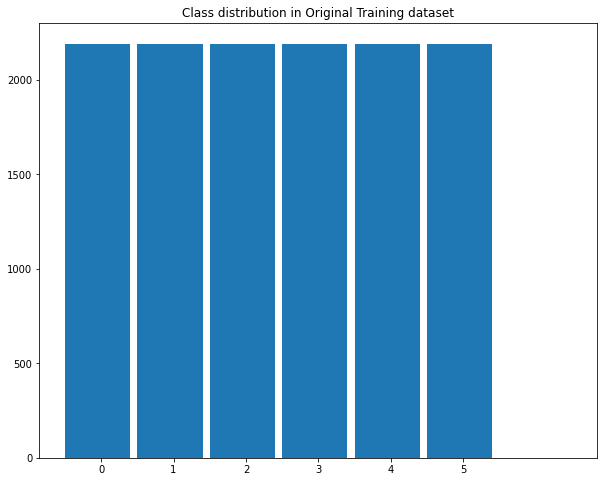

Augmented training dataset contains:
24948 images of size 100x100x3 with 4158 images per scene category



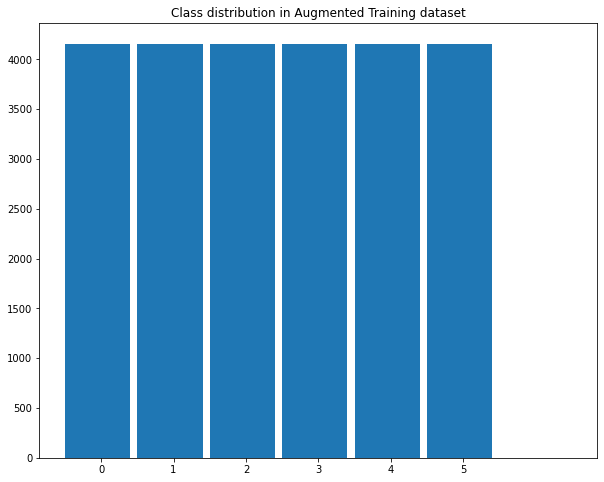

Testing dataset contains:
2622 images of size 100x100x3 with 437 images per scene category



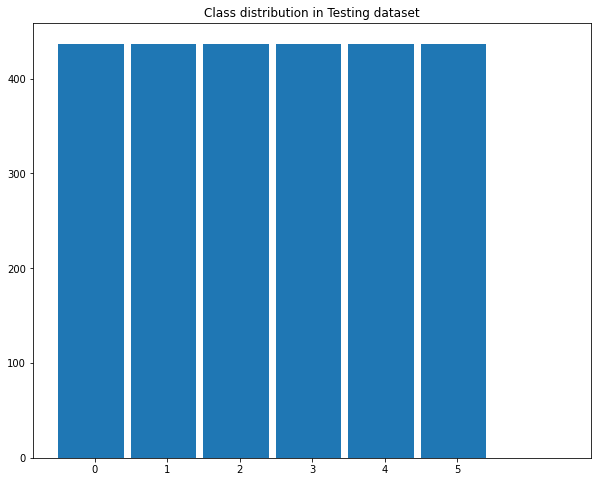

In [0]:
print('Original training dataset contains:')

print('%d images of size %dx%dx%d with %d images per scene category\n'%(train_X.shape[0], train_X.shape[1], train_X.shape[2], train_X.shape[3], minimum_train))

plt.figure(figsize=(10,8))
plt.hist(train_Y, np.linspace(-0.5, 6.5, 8), width=0.9)
plt.xticks(np.linspace(0,5,6))
plt.title("Class distribution in Original Training dataset")
plt.savefig("class_distribution_train", transparent=True)
plt.show()

print('Augmented training dataset contains:')

print('%d images of size %dx%dx%d with %d images per scene category\n'%(augmented_train_X.shape[0], augmented_train_X.shape[1], augmented_train_X.shape[2], augmented_train_X.shape[3], minimum_augmented_train))

plt.figure(figsize=(10,8))
plt.hist(augmented_train_Y, np.linspace(-0.5, 6.5, 8), width=0.9)
plt.xticks(np.linspace(0,5,6))
plt.title("Class distribution in Augmented Training dataset")
plt.savefig("class_distribution_augmented_train", transparent=True)
plt.show()

print('Testing dataset contains:')

print('%d images of size %dx%dx%d with %d images per scene category\n'%(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3], minimum_test))

plt.figure(figsize=(10,8))
plt.hist(Y_test, np.linspace(-0.5, 6.5, 8), width=0.9)
plt.xticks(np.linspace(0,5,6))
plt.title("Class distribution in Testing dataset")
plt.savefig("class_distribution_test", transparent=True)
plt.show()

Next we shuffle the original dataset, augmented dataset and testing dataset

In [0]:
augmented_train_indices = np.arange(augmented_train_X.shape[0])
np.random.shuffle(augmented_train_indices)

In [0]:
train_indices = np.arange(train_X.shape[0])
np.random.shuffle(train_indices)
test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)

In [0]:
X_train = train_X[train_indices]
Y_train = train_Y[train_indices]

In [0]:
augmented_X_train = augmented_train_X[augmented_train_indices]
augmented_Y_train = augmented_train_Y[augmented_train_indices]

In [0]:
X_test = X_test[test_indices]
Y_test = Y_test[test_indices]

Next, we create the ResNet model using the pretrained ResNet50 model

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Convolution2D, MaxPooling2D

#create the ResNet model by calling the ResNet50 method from the Keras API
res_conv = ResNet50(include_top=False,
                    weights='imagenet',
                    input_tensor=None,
                    input_shape=(100,100,3),
                    pooling=None,classes=1000)
model = Sequential()
model.add(res_conv)

#these convolutional layers are added to reduce the number of trainable parameters

model.add(keras.layers.Convolution2D(64, (3, 3), padding='same', input_shape=(100,100,3), activation='relu'))
model.add(keras.layers.Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

94773248/94765736 [==============================] - 2s 0us/step


In [0]:
#we set all the layers from the imported ResNet50 model to trainable as we would like to train all the layers. 
#The imported ResNet50 model with its initialized ImageNet weights is only used as a starting point for our model 
for layer in res_conv.layers:
    layer.trainable = True

In [0]:
#compiling our model using the Sparse Categorical Crossentropy loss functions since our labels are integer values and not one-hot encoded. 
#The RMSprop optimization method is also used. All these hyper-parameters were obtained using a random search.  
model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), metrics=['accuracy'])

In [0]:
#we print out the model summary to see the structure of our model and the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 64)          1179712   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 128)         147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 128)         0

In [0]:
#fitting our model with the original dataset
#only 10 epochs are used as the number of parameters are a lot and Google Colab using allows a model to run for a certain amount of time
history =model.fit(X_train, Y_train,
                            batch_size=16,
                            epochs=10,
                            validation_split=0.2,
                            verbose=1)

Epoch 1/10
658/658 [==============================] - 265s 402ms/step - loss: 0.6281 - accuracy: 0.7739 - val_loss: 2.3833 - val_accuracy: 0.6810
Epoch 2/10
658/658 [==============================] - 264s 401ms/step - loss: 0.3007 - accuracy: 0.9059 - val_loss: 0.5412 - val_accuracy: 0.8650
Epoch 3/10
658/658 [==============================] - 264s 401ms/step - loss: 0.2186 - accuracy: 0.9364 - val_loss: 1.0497 - val_accuracy: 0.8654
Epoch 4/10
658/658 [==============================] - 267s 406ms/step - loss: 0.1740 - accuracy: 0.9494 - val_loss: 0.5259 - val_accuracy: 0.9042
Epoch 5/10
658/658 [==============================] - 266s 405ms/step - loss: 0.1274 - accuracy: 0.9631 - val_loss: 0.9279 - val_accuracy: 0.8962
Epoch 6/10
658/658 [==============================] - 267s 405ms/step - loss: 0.1170 - accuracy: 0.9699 - val_loss: 2.0681 - val_accuracy: 0.8084
Epoch 7/10
658/658 [==============================] - 263s 400ms/step - loss: 0.0968 - accuracy: 0.9761 - val_loss: 1.0553 -

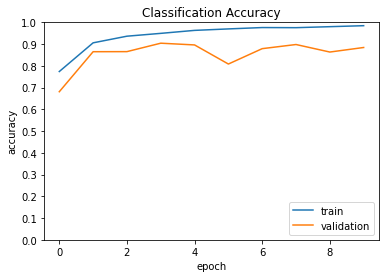

In [0]:
#we plot the results of our training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], )
plt.title('Classification Accuracy')
plt.ylabel('accuracy')
plt.yticks(np.linspace(0, 1.0, 11))
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig("dataset_acc", transparent=True)
plt.show()

In [0]:
#evaluating our model that was trained on the original dataset, on the test dataset 
model.evaluate(X_test, Y_test)

82/82 [==============================] - 10s 118ms/step - loss: 1.1023 - accuracy: 0.8780


[1.1023170948028564, 0.8779557347297668]

In [0]:
#we reset the layers on the ResNet50 model to allow it to retrain on the augmented dataset
for layer in res_conv.layers:
    layer.trainable = True

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

In [0]:
#fitting our model with the augmented dataset
#only 10 epochs are used as the number of parameters are a lot and Google Colab using allows a model to run for a certain amount of time
history1 =model.fit(augmented_X_train, augmented_Y_train,
                            batch_size=16,
                            epochs=10,
                            validation_split=0.2,
                            verbose=1)

Epoch 1/10
1248/1248 [==============================] - 500s 401ms/step - loss: 0.2266 - accuracy: 0.9384 - val_loss: 0.1938 - val_accuracy: 0.9451
Epoch 2/10
1248/1248 [==============================] - 501s 401ms/step - loss: 0.1468 - accuracy: 0.9631 - val_loss: 0.2034 - val_accuracy: 0.9457
Epoch 3/10
1248/1248 [==============================] - 497s 398ms/step - loss: 0.1170 - accuracy: 0.9731 - val_loss: 0.4415 - val_accuracy: 0.9557
Epoch 4/10
1248/1248 [==============================] - 498s 399ms/step - loss: 0.1099 - accuracy: 0.9785 - val_loss: 0.2166 - val_accuracy: 0.9583
Epoch 5/10
1248/1248 [==============================] - 499s 400ms/step - loss: 0.0961 - accuracy: 0.9805 - val_loss: 0.4874 - val_accuracy: 0.9497
Epoch 6/10
1248/1248 [==============================] - 500s 401ms/step - loss: 0.1019 - accuracy: 0.9830 - val_loss: 0.6802 - val_accuracy: 0.9333
Epoch 7/10
1248/1248 [==============================] - 500s 401ms/step - loss: 0.0912 - accuracy: 0.9837 - val_

In [0]:
#we plot the results of our training
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'], )
plt.title('Classification Accuracy')
plt.ylabel('accuracy')
plt.yticks(np.linspace(0, 1.0, 11))
plt.xlabel('epoch')
plt.legend(['augmented_train', 'augmented_validation'], loc='lower right')
plt.savefig("augmented_dataset_acc", transparent=True)
plt.show()

In [0]:
#evaluating our model that was trained on the original dataset, on the test dataset
model.evaluate(X_test, Y_test)

In [0]:
#we now plot the training accuracy of the original and augmented datasets against each other to see which ones performed better
plt.plot(history.history['accuracy'])
plt.plot(history1.history['accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.yticks(np.linspace(0, 1.0, 11))
plt.legend(['train', 'augmented_train'], loc='lower right')
plt.savefig("dataset_comparison_acc", transparent=True)
plt.show()

In [0]:
#we now plot the validation accuracy of the original and augmented datasets against each other to see which ones performed better
plt.plot(history.history['val_accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Validation Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.yticks(np.linspace(0, 1.0, 11))
plt.legend(['validation_train', 'validation_augmented_train'], loc='lower right')
plt.savefig("dataset_comparison_val_acc", transparent=True)
plt.show()

Conclusion: Data augmentation techniques, specifically horizonatal flipping, increases the classification accuracy of the ResNet model. 

# Experiment 2

Aim: Experiment 2 investigates whether decreasing the size/resolution of the scene images lessens the emergence of objects detectors

In [0]:
def create_dataset(path_folders_1, path_folders_2, size):
    image_data = []
    labels = []
    class_labels_dict = {'buildings':0, 'forest':1, 'glacier':2, 'sea':3, 'street':4, 'mountain':5}
    num_images_per_class = []

    #this gets the number of images in each class. We need this so that we can get the class with lowest number of images.
    #We need this so that we can balance the classes.
    for folder in path_folders_1:
        counter = 0
        for img_path in folder.glob("*.jpg"):
            counter+=1
        num_images_per_class.append(counter)
    min_num_images_to_read = min(num_images_per_class)
    
    for folder in path_folders_2:
        class_label = str(folder).split("/")[-1]
        counter = 0
      
        #iterate over folder and select the images in each folder
        for img_path in folder.glob("*.jpg"):
            if (counter < min_num_images_to_read):
              img = image.load_img(img_path, target_size=size)
              img_array = image.img_to_array(img)
              image_data.append(img_array)
              labels.append(class_labels_dict[class_label])
              counter+=1

    return image_data, labels, min_num_images_to_read

In [0]:
#we first import the library that contains the ResNet50 model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Convolution2D

In [0]:
#ResNet function takes as input parameters the image size/resolution that the ResNet should take and 
#produces as output the ResNet model for that image size/resolution

def ResNet(size, pooling_method=None):
    res_conv = ResNet50(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(size,size,3),
                        pooling=pooling_method,
                        classes=1000)
    model = Sequential()
    model.add(res_conv)
    
    if pooling_method == None:
        model.add(keras.layers.Convolution2D(64, (3, 3), padding='same', activation='relu'))
        model.add(keras.layers.Convolution2D(64, (3, 3), padding='same', activation='relu'))
        model.add(keras.layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
        model.add(keras.layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
        model.add(keras.layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
        model.add(keras.layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='softmax'))

    for layer in res_conv.layers:
        layer.trainable = True
    
    return model

In [0]:
size_accuracy=[]
size_loss=[]
size_history_of_model=[]

#the size_experiment function creates the 4 datasets for the 4 different images sizes/resolutions. 
#It then produces a summary of the model that is used for the experiment and trains the model

def size_experiment(size_length):
  
    path = Path(r'/content/seg_train/seg_train')
    folders_path_1 = path.glob("*")
    folders_path_2 = path.glob("*")
    train_X, train_Y, m_train = create_dataset(folders_path_1, folders_path_2, size=(size_length,size_length))

    path = Path(r'/content/seg_test/seg_test')
    folders_path_1 = path.glob("*")
    folders_path_2 = path.glob("*")
    X_test, Y_test, m_test= create_dataset(folders_path_1, folders_path_2, size=(size_length,size_length))

    train_X = np.array(train_X)
    train_Y = np.array(train_Y).reshape(len(train_Y), 1)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test).reshape(len(Y_test), 1)
    
    train_indices = np.arange(train_X.shape[0])
    np.random.shuffle(train_indices)
    test_indices = np.arange(X_test.shape[0])
    np.random.shuffle(test_indices)
    
    X_train = train_X[train_indices]
    Y_train = train_Y[train_indices]
    X_test = X_test[test_indices]
    Y_test = Y_test[test_indices]

    resnet_model = ResNet(size_length, pooling_method=None)
    
    resnet_model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=1e-4), metrics=['accuracy']) 
    
    resnet_model.summary()

    history = resnet_model.fit(X_train, Y_train,
                            batch_size=8,
                            epochs=7,
                            validation_split=0.25,
                            verbose=1)
    

    acc, lss = resnet_model.evaluate(X_test, Y_test)
    size_history_of_model.append(history)
    size_accuracy.append(acc)
    size_loss.append(lss)
    

In [0]:
size_experiment(75)

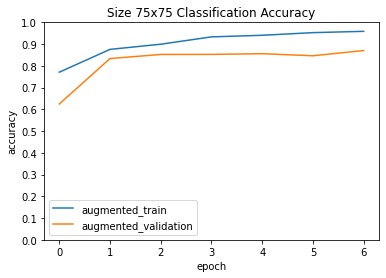

In [0]:
#we plot the results of the model

hist_1 = size_history_of_model[0]

plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('Size 75x75 Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.yticks(np.linspace(0, 1.0, 11))
plt.legend(['augmented_train', 'augmented_validation'])
plt.savefig("size_experiment_1_acc_copy", transparent=True)
plt.show()

In [0]:
size_experiment(100)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 64)          1179712   
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 128)        

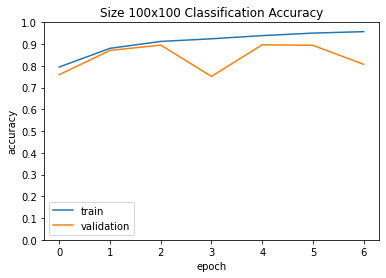

In [0]:
#we plot the results of the model
hist_1 = size_history_of_model[1]

plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('Size 100x100 Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.yticks(np.linspace(0, 1.0, 11))
plt.legend(['train', 'validation'])
plt.savefig("size_experiment_2_acc_copy", transparent=True)
plt.show()

In [0]:
size_experiment(125)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 64)          1179712   
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 128)        

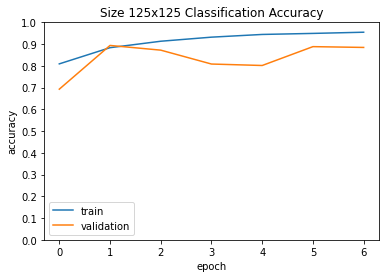

In [0]:
#we plot the results of the model
hist_1 = size_history_of_model[2]

plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('Size 125x125 Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.yticks(np.linspace(0, 1.0, 11))
plt.legend(['train', 'validation'])
plt.savefig("size_experiment_3_acc", transparent=True)
plt.show()

In [0]:
size_experiment(150)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 5, 64)          1179712   
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 5, 64)          36928     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 5, 5, 128)         147584    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 5, 5, 128)         147584    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 5, 128)        

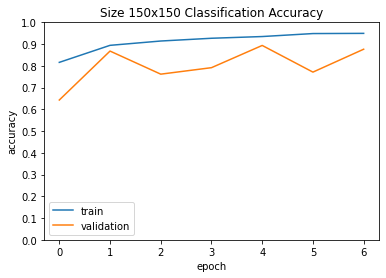

In [0]:
#we plot the results of the model
hist_1 = size_history_of_model[3]

plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('Size 150x150 Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.yticks(np.linspace(0, 1.0, 11))
plt.legend(['train', 'validation'])
plt.savefig("size_experiment_4_acc", transparent=True)
plt.show()

Conclusion: Decreasing the image resolution/size of the scene images doesn't lessen the emergence of object detectors

# Experiment 3

Aim: Experiment investigates whether pooling methods such as Average Pooling and Max Pooling can increase the classification accuracy of the ResNet model

In [0]:
def create_dataset(path_folders_1, path_folders_2, size):
    image_data = []
    labels = []
    class_labels_dict = {'buildings':0, 'forest':1, 'glacier':2, 'sea':3, 'street':4, 'mountain':5}
    num_images_per_class = []

    #this gets the number of images in each class. We need this so that we can get the class with lowest number of images.
    #We need this so that we can balance the classes.
    for folder in path_folders_1:
        counter = 0
        for img_path in folder.glob("*.jpg"):
            counter+=1
        num_images_per_class.append(counter)
    min_num_images_to_read = min(num_images_per_class)
    
    for folder in path_folders_2:
        class_label = str(folder).split("/")[-1]
        counter = 0
      
        #iterate over folder and select the images in each folder
        for img_path in folder.glob("*.jpg"):
            if (counter < min_num_images_to_read):
              img = image.load_img(img_path, target_size=size)
              img_array = image.img_to_array(img)
              image_data.append(img_array)
              labels.append(class_labels_dict[class_label])
              counter+=1

    return image_data, labels, min_num_images_to_read

In [0]:
#we first import the library that contains the ResNet50 model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Convolution2D

In [0]:
#this is the same ResNet function from Experiment 2 and was just copied and pasted here for convenience
def ResNet(size, pooling_method=None):
    res_conv = ResNet50(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(size,size,3),
                        pooling=pooling_method,
                        classes=1000)
    model = Sequential()
    model.add(res_conv)
    
    if pooling_method == None:
        model.add(keras.layers.Convolution2D(64, (3, 3), padding='same', activation='relu'))
        model.add(keras.layers.Convolution2D(64, (3, 3), padding='same', activation='relu'))
        model.add(keras.layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
        model.add(keras.layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
        model.add(keras.layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
        model.add(keras.layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='softmax'))

    for layer in res_conv.layers:
        layer.trainable = True
    
    return model

In [0]:
pool_accuracy=[]
pool_loss=[]
pool_history_of_model = []

#creating the training and testing datasets
path = Path(r'/content/seg_train/seg_train')
folders_path_1 = path.glob("*")
folders_path_2 = path.glob("*")
train_X, train_Y, minimum_train = create_dataset(folders_path_1, folders_path_2, size=(100,100))

path = Path(r'/content/seg_test/seg_test')
folders_path_1 = path.glob("*")
folders_path_2 = path.glob("*")
X_test, Y_test, minimum_test = create_dataset(folders_path_1, folders_path_2, size=(100, 100))

train_X = np.array(train_X)
train_Y = np.array(train_Y).reshape(len(train_Y), 1)
X_test = np.array(X_test)
Y_test = np.array(Y_test).reshape(len(Y_test), 1)

#shuffling the training and testing datasets
train_indices = np.arange(train_X.shape[0])
np.random.shuffle(train_indices)
test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)

X_train = train_X[train_indices]
Y_train = train_Y[train_indices]
X_test = X_test[test_indices]
Y_test = Y_test[test_indices]

In [0]:
#The pooling_experiment functions takes as input the type of pooling method that should be used with the ResNet and then trains it using this pooling method.
#This function also evaluates the model on the testing set and displays the results thereof

def pooling_experiment(pool):
    
    resnet_model = ResNet(100, pooling_method=pool)
    
    resnet_model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=1e-4), metrics=['accuracy']) 
    
    resnet_model.summary()
    history = resnet_model.fit(X_train, Y_train,
                            batch_size=8,
                            epochs=10,
                            validation_split=0.25,
                            verbose=1)
    
    pool_history_of_model.append(history)
    acc, lss = resnet_model.evaluate(X_test, Y_test)
    pool_accuracy.append(acc)
    pool_loss.append(lss)


In [0]:
pooling_experiment(None)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 64)          1179712   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         1

In [0]:
pooling_experiment('avg')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 6150      
Total params: 25,692,038
Trainable params: 25,638,918
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/10
617/617 [==============================] - 246s 399ms/step - loss: 0.5067 - accuracy: 0.8378

In [0]:
pooling_experiment('max')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 6150      
Total params: 25,692,038
Trainable params: 25,638,918
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/10
617/617 [==============================] - 246s 399ms/step - loss: 1.0209 - accuracy: 0.7966

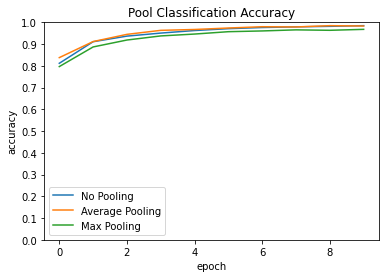

In [0]:
#visualizing the results for the training accuracy of each pooling method
plt.plot(pool_history_of_model[0].history['accuracy'])
plt.plot(pool_history_of_model[1].history['accuracy'])
plt.plot(pool_history_of_model[2].history['accuracy'])
plt.title('Pool Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.yticks(np.linspace(0, 1.0, 11))
plt.legend(['No Pooling', 'Average Pooling', 'Max Pooling'])
plt.savefig("pool_experiment_acc", transparent=True)
plt.show()

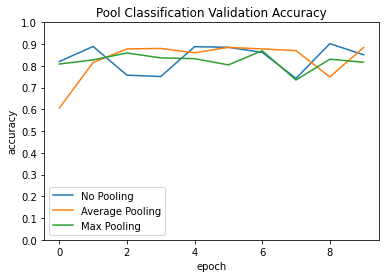

In [0]:
#visualizing the results for the validation accuracy of each pooling method
plt.plot(pool_history_of_model[0].history['val_accuracy'])
plt.plot(pool_history_of_model[1].history['val_accuracy'])
plt.plot(pool_history_of_model[2].history['val_accuracy'])
plt.title('Pool Classification Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.yticks(np.linspace(0, 1.0, 11))
plt.legend(['No Pooling', 'Average Pooling', 'Max Pooling'])
plt.savefig("pool_experiment_val_acc", transparent=True)
plt.show()

Conclusion: Average Pooling has a positive impact on the classification accuracy of the ResNet model whereas Max Pooling has a slight negative impact on the classification accuracy